# Homework 4- Table of Contents

### [Task 1. Propensity score matching](#1)
- [1.1. A naive analysis](#11)

- [1.2. A closer look at the data](#12)

- [1.3. A propensity score model](#13)

- [1.4. Balancing the dataset via matching](#14)

- [1.5. Balancing the groups further](#15)

- [1.6. A less naive analysis](#14)


### [Task 2. Applied ML](#2)
- [2.1. Load data](#21)

- [2.2. Train data with random forest](#22)

### Imports - libraries

In [403]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from pandas.plotting import scatter_matrix
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from scipy import stats
import seaborn as sns
%matplotlib inline

### Imports - data

In [356]:
df = pd.read_csv('lalonde.csv', index_col = 0)

We check that data doesn't have any missing/null values:

In [357]:
df.isnull().values.any()

False

## Task 1. Propensity Score Matching <a class="anchor" id="1"></a>

### Assignment Instructions
In this exercise, you will apply propensity score matching, which we discussed in lecture 5 ("Observational studies"), in order to draw conclusions from an observational study.

We will work with a by-now classic dataset from Robert LaLonde's study "Evaluating the Econometric Evaluations of Training Programs" (1986). The study investigated the effect of a job training program ("National Supported Work Demonstration") on the real earnings of an individual, a couple of years after completion of the program. Your task is to determine the effectiveness of the "treatment" represented by the job training program.

Dataset description

- `treat`: 1 if the subject participated in the job training program, 0 otherwise
- `age`: the subject's age
- `educ`: years of education
- `race`: categorical variable with three possible values: Black, Hispanic, or White
- `married`: 1 if the subject was married at the time of the training program, 0 otherwise
- `nodegree`: 1 if the subject has earned no school degree, 0 otherwise
- `re74`: real earnings in 1974 (pre-treatment)
- `re75`: real earnings in 1975 (pre-treatment)
- `re78`: real earnings in 1978 (outcome)

### 1.1. A Naive Analysis<a class="anchor" id="11"></a>

At this point, we will start by comparing the distribution of the outcome variable (re78) between the two groups:

In [358]:
#create two distinct data frames for each group
treated = df[(df.treat ==1)]
non_treated = df[(df.treat == 0)]

Let's check the general numerical values of real earning in the year of 1978 for both groups:

In [359]:
#Real earnings description for people who took the job trainig program
treated.re78.describe()

count      185.000000
mean      6349.143530
std       7867.402218
min          0.000000
25%        485.229800
50%       4232.309000
75%       9642.999000
max      60307.930000
Name: re78, dtype: float64

In [360]:
#Real earnings description for people who did not take the job trainig program
non_treated.re78.describe()

count      429.000000
mean      6984.169742
std       7294.161791
min          0.000000
25%        220.181300
50%       4975.505000
75%      11688.820000
max      25564.670000
Name: re78, dtype: float64

**Observation:**

Considering what we know so far, there are several points that stand out in the descriptions above. 
One can see that eventhough the mean is higher for the non-treated group, with a relative difference of approximately 9%, the maximium value, on the other side, is higer in the treated group with a relative difference of approximately 57%, which is a huge difference.

Let's represent the values above with some plots. Note that for the following representations we consider relative values, since those are more meaningful comparing two groups of different size.

In [361]:
def plot_hist(feature, title1, title2):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey = True);
    
    treated_values = treated[feature]
    non_treated_values = non_treated[feature]
    
    #relative weight parameters for hist plot
    weigths_treated = np.zeros_like(treated_values) + 1. / treated_values.size
    weigths_non_treated = np.zeros_like(non_treated_values) + 1. / non_treated_values.size 
    
    treated_values.plot.hist(ax = axes[0],weights=weigths_treated, title=title1)
    non_treated_values.plot.hist(ax = axes[1], weights=weigths_non_treated,title=title2)  

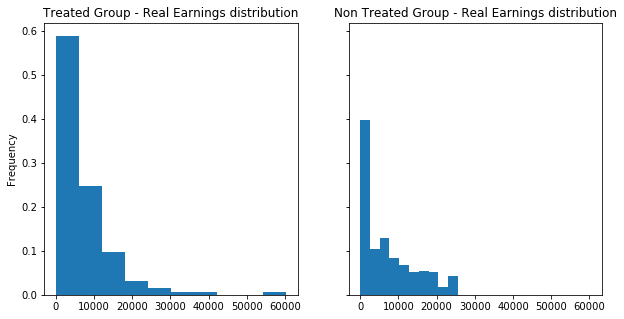

In [362]:
plot_hist('re78', 'Treated Group - Real Earnings distribution','Non Treated Group - Real Earnings distribution')

A naive "researcher" can conclude from this superficial analysis that ------------want to make propper hist with same bins width for both histograms----

### 1.2. A closer look at the data<a class="anchor" id="12"></a>

Let's take a closer look at the data before jumping to conclusions:

One can not just take into account the real earning in the year of 1978 to justify the  effectiveness of the "treatment" represented by the job training program. This could be biased. A good analysis should consider the "story" of a person, since it's obvious that people with higher education, or those who already had higher real earning values in the past few years are more likely to earn more, independently if they took the program.

For each feature in the dataset, we compare its distribution in the treated group with its distribution in the control group, using plots and numbers. 

In [391]:
def plot_bars(feature, title, print_values = False):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey = True);
    
    treated_values = (treated[feature].value_counts()/treated[feature].size).sort_index()
    non_treated_values = (non_treated[feature].value_counts()/non_treated[feature].size).sort_index()
   
    if (print_values == True):
        print('The distribution in the treated group takes the following values: \n{}'.format(treated_values))
        print('The distribution in the non treated group takes the following values: \n{}'.format(non_treated_values))
    
    treated_values.plot.bar(ax = axes[0],title=('Treated Group - '+ title + ' Distribution'))
    non_treated_values.plot.bar(ax = axes[1],title=('Non Treated Group - '+ title + ' Distribution'))

**Is the `age` equal distributed in both groups?**

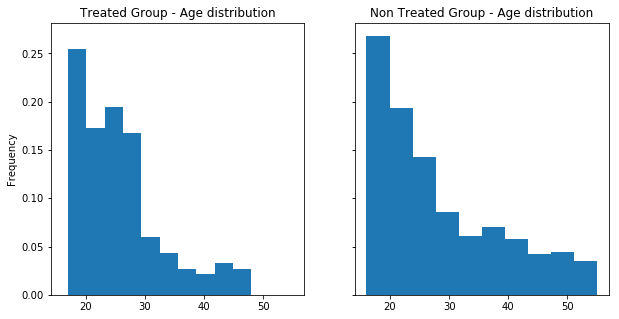

In [386]:
plot_hist('age', 'Treated Group - Age distribution','Non Treated Group - Age distribution')

We can't see major diferences between these two distributions, which means that the data is simillarly distributed in both groups.

**Do both groups have a simillar `education`?**

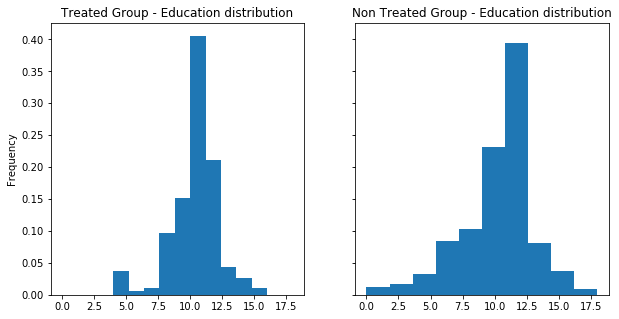

In [387]:
plot_hist('educ', 'Treated Group - Education distribution','Non Treated Group - Education distribution')

Let's compare the mean of education years in both groups:

In [388]:
mean_relativeDifference = treated.educ.mean()-non_treated.educ.mean()/treated.educ.mean()
print("There's a {}% difference when comparing the mean of years of education for both groups".
      format(mean_relativeDifference))

There's a 9.356627879825371% difference when comparing the mean of years of education for both groups


We can verify that the treated group has a higher average for years of education, which is likely to be correlated with higher real earnings as well.

**Are the three different `races` equally distributed in both groups?**

The distribution in the treated group takes the following values: 
 0    0.156757
1    0.843243
Name: black, dtype: float64
The distribution in the non treated group takes the following values: 
0    0.797203
1    0.202797
Name: black, dtype: float64


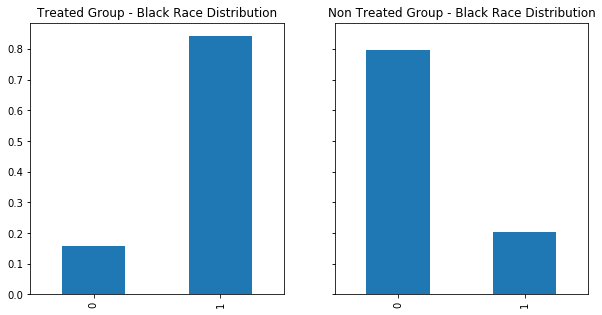

In [389]:
plot_bars('black', 'Black Race', print_values = True)

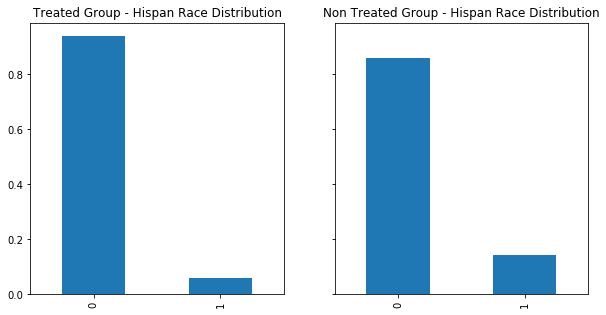

In [369]:
plot_bars('hispan', 'Hispan Race')

We can verify that the hispanic race is a minority in both groups. However, the same does not apply to the black race. In fact, more that 80% of people in the trated group belong to black race, in comparison with 20% in the non-treated group. 

**How is the `Marital status` distribuded in this two groups**

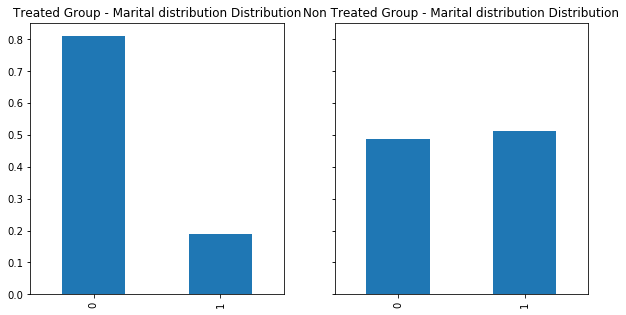

In [370]:
plot_bars('married','Marital distribution')

The Marital distribution is not exactly the same. However, one should also take into account that this parameter is not so likely to influence the real earnings. Since `married` is a dichotomous variable, let's check the Point-biserial correlation coefficient between these two features:

In [412]:
stats.pointbiserialr(df['married'], df['re78'])

PointbiserialrResult(correlation=0.16235762667544129, pvalue=5.3062440838823211e-05)

We can verify they these features don't have a strong dependence.

**Is the distribution of people who got `no degrees` similar in both groups?**

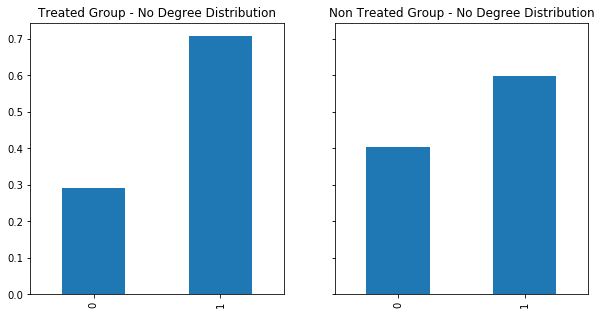

In [413]:
plot_bars('nodegree','No Degree')

We verify that the number of people with no degrees is simillar in both cases.

### 1.3. A propensity score model<a class="anchor" id="13"></a>

### 1.4. Balancing the dataset via matching <a class="anchor" id="14"></a>

### 1.5. Balancing the groups further <a class="anchor" id="15"></a>

### 1.6. A less naive analysis <a class="anchor" id="16"></a>

TO THINK ABOUT: WHICH FACTORS CAN INFLUENCE ONE GROUP INSTEAD OF THE OTHER? IS THERE ANY BIAS HERE?
    CAN WE CONSIDER THAT PEOPLE WHO TOOK THE JOB TRAINING PROGRAM ARE FROM THE BEGINNING MORE LIKELY TO EARN MORE
    SINCE THEY SHOW TO BE MOTIVATED IN SO? - CHECK CAREFULLY WHICH TYPE OF PEOPLE PARTICIPATED IN THE PROGRAM

## Task 2. Swiss Unemployment Rates Analysis - *amstat* dataset <a class="anchor" id="2"></a>

### Assignment Instructions

We are going to build a classifier of news to directly assign them to 20 news categories. Note that the pipeline that you will build in this exercise could be of great help during your project if you plan to work with text!

Load the 20newsgroup dataset. It is, again, a classic dataset that can directly be loaded using sklearn (link).
TF-IDF, short for term frequency–inverse document frequency, is of great help when if comes to compute textual features. Indeed, it gives more importance to terms that are more specific to the considered articles (TF) but reduces the importance of terms that are very frequent in the entire corpus (IDF). Compute TF-IDF features for every article using TfidfVectorizer. Then, split your dataset into a training, a testing and a validation set (10% for validation and 10% for testing). Each observation should be paired with its corresponding label (the article category).

Train a random forest on your training set. Try to fine-tune the parameters of your predictor on your validation set using a simple grid search on the number of estimator "n_estimators" and the max depth of the trees "max_depth". Then, display a confusion matrix of your classification pipeline. Lastly, once you assessed your model, inspect the feature_importances_ attribute of your random forest and discuss the obtained results.

### 2.1. Pick a DataSet to analyse <a class="anchor" id="21"></a>

### 2.2. Choropleth map of Cantonal Unemployment Rates  <a class="anchor" id="22"></a>